In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 33.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from math import sin, cos, pi
import cv2, os
from tqdm.auto import tqdm
from keras import layers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model

In [ ]:
class config:           #Xác định lớp xác định lược đồ tăng dữ liệu
    horizontal_flip = False
    rotation_augmentation = True
    brightness_augmentation = True
    shift_augmentation = True
    random_noise_augmentation = True

    rotation_angles = [12]    # Góc quay theo độ (bao gồm cả quay theo chiều kim đồng hồ và ngược chiều kim đồng hồ)
    pixel_shifts = [12]    # Số lượng dịch chuyển ngang & dọc tính bằng pixel (bao gồm dịch chuyển từ tất cả 4 góc)

    NUM_EPOCHS = 100
    BATCH_SIZE = 64

# Loading Data

In [ ]:
# Hình
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='.', c='b')
    plt.title(title)

## Exploring Data

In [ ]:
train_data.head(5)     #Chứa tọa độ điểm chính của khuôn mặt và hình ảnh để đào tạo

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [ ]:
test_data.head()      #Chứa hình ảnh điểm chính của khuôn mặt để test, không gắn nhãn tọa độ điểm chính

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
print("Length of train data:", len(train_data))

Length of train data: 7049


**Find columns having Null values and their counts**

In [ ]:
train_data.isnull().sum()   #Xác định cột nào thiếu giá trị

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

#### 68% dữ liệu bị thiếu cho một số điểm chính

# Tiền xử lý dữ liệu

In [ ]:
# Tiền xử lý dữ liệu

clean_train_data = train_data.dropna()  #Xóa các hàng chứa giá trị NaN
print("clean_train_data shape:", np.shape(clean_train_data))

unclean_train_data = train_data.fillna(method = 'ffill')  #Mặc định là 'ffill', điền về phía trước
print("unclean_train_data shape:", np.shape(unclean_train_data))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)


In [ ]:
train_data.fillna(method = 'ffill')

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,67.029093,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,66.626011,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,67.515161,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,59.255347,36.065143,73.942694,34.624653,37.478531,39.398041,...,66.724988,72.600433,71.862041,34.232759,77.339429,51.599453,75.963592,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)
CPU times: user 13.9 s, sys: 997 ms, total: 14.9 s
Wall time: 16.2 s


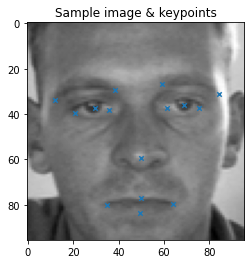

In [ ]:
%%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images:", np.shape(clean_train_images))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints:", np.shape(clean_train_keypoints))
test_images = load_images(test_data)
print("Shape of test_images:", np.shape(test_images))

train_images = clean_train_images        #Tăng cường dữ liệu cho hình ảnh và các điểm chính sau khi vận hành sạch sẽ
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[152], clean_train_keypoints[152], axis, "Sample image & keypoints")

unclean_train_images = load_images(unclean_train_data)
print("Shape of unclean_train_images:", np.shape(unclean_train_images))
unclean_train_keypoints = load_keypoints(unclean_train_data)
print("Shape of unclean_train_keypoints:", np.shape(unclean_train_keypoints))

#kết hợp mảng
train_images = np.concatenate((train_images, unclean_train_images))
train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

# Augmentation

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if config.horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images:", np.shape(flipped_train_images))
    print("Shape of flipped_train_keypoints:", np.shape(flipped_train_keypoints))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[19], flipped_train_keypoints[19], axis, "Horizontally Flipped")


Augmenting for angles (in degrees): 
12  -12  Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)


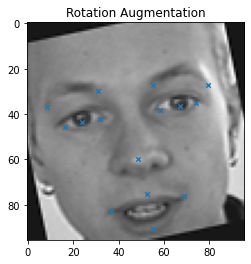

In [ ]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in config.rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)

    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

print()

#Dương và tiêu cực hai góc
if config.rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("Shape of rotated_train_images:", np.shape(rotated_train_images))
    print("Shape of rotated_train_keypoints:", np.shape(rotated_train_keypoints))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[19], rotated_train_keypoints[19], axis, "Rotation Augmentation")

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


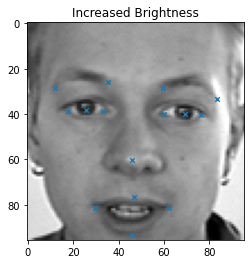

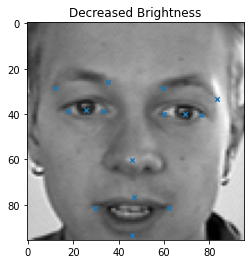

In [ ]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

#Hai loại biến đổi sáng và tối
if config.brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print("Shape of altered_brightness_train_images:", np.shape(altered_brightness_train_images))
    print("Shape of altered_brightness_train_keypoints:", np.shape(altered_brightness_train_keypoints))
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[19], altered_brightness_train_keypoints[19], axis, "Increased Brightness")
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+19], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+19], axis, "Decreased Brightness")

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


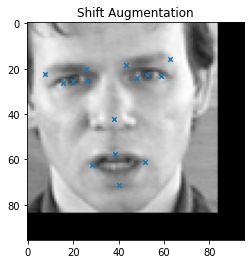

In [ ]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in config.pixel_shifts:    # Tăng cường trên một số giá trị thay đổi pixel
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

#Dịch chuyển bốn hướng (di chuyển có ngưỡng)
if config.shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print("Shape of shifted_train_images:", np.shape(shifted_train_images))
    print("Shape of shifted_train_keypoints:", np.shape(shifted_train_keypoints))
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[19], shifted_train_keypoints[19], axis, "Shift Augmentation")

Shape of noisy_train_images: (2140, 96, 96, 1)


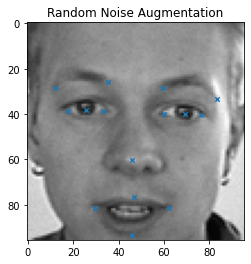

In [ ]:
#Thêm noise ngẫu nhiên
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if config.random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print("Shape of noisy_train_images:", np.shape(noisy_train_images))
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[19], clean_train_keypoints[19], axis, "Random Noise Augmentation")

## Visualize Train images & corresponding Keypoints

Shape of final train_images: (26239, 96, 96, 1)
Shape of final train_keypoints: (26239, 30)

Clean Train Data: 


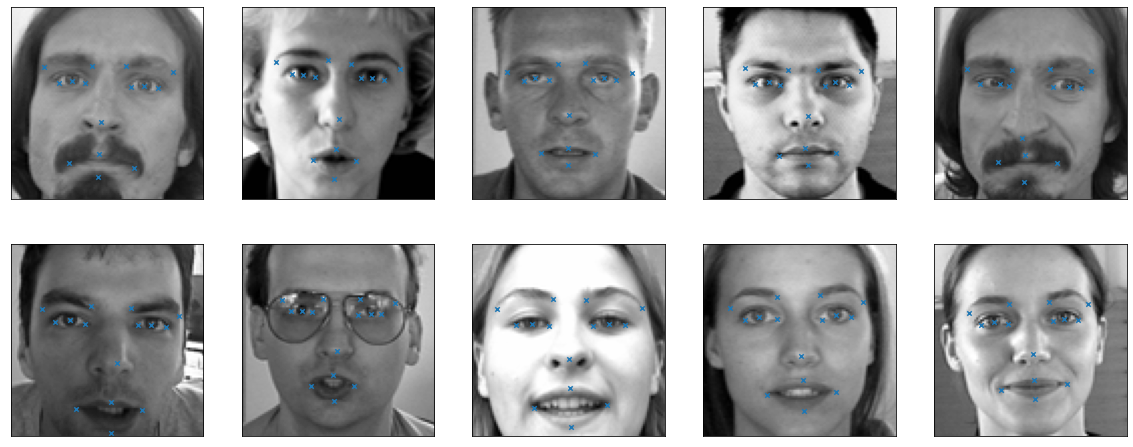

Unclean Train Data: 


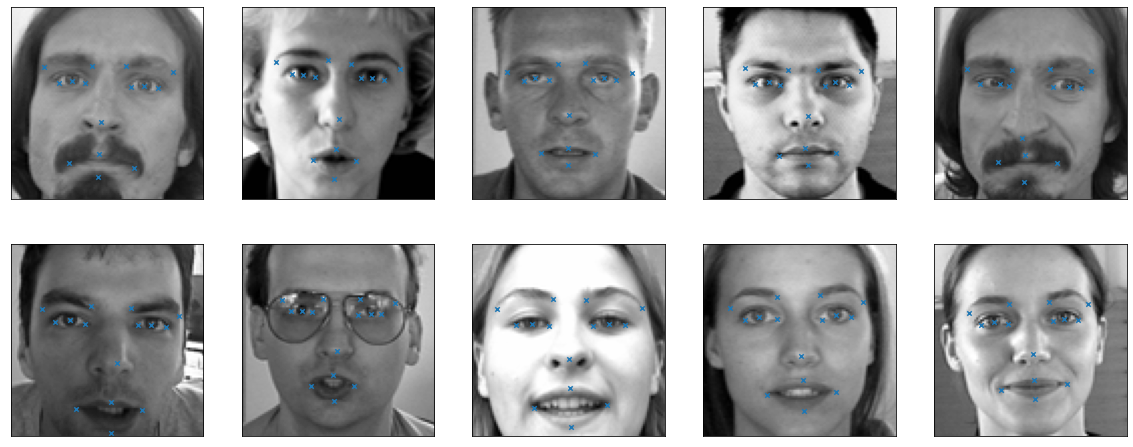

Rotation Augmentation: 


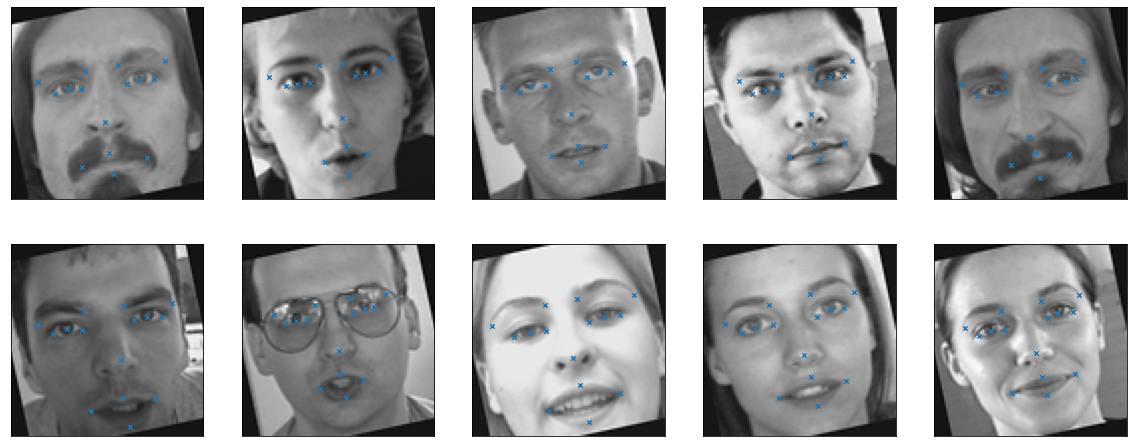

Brightness Augmentation: 


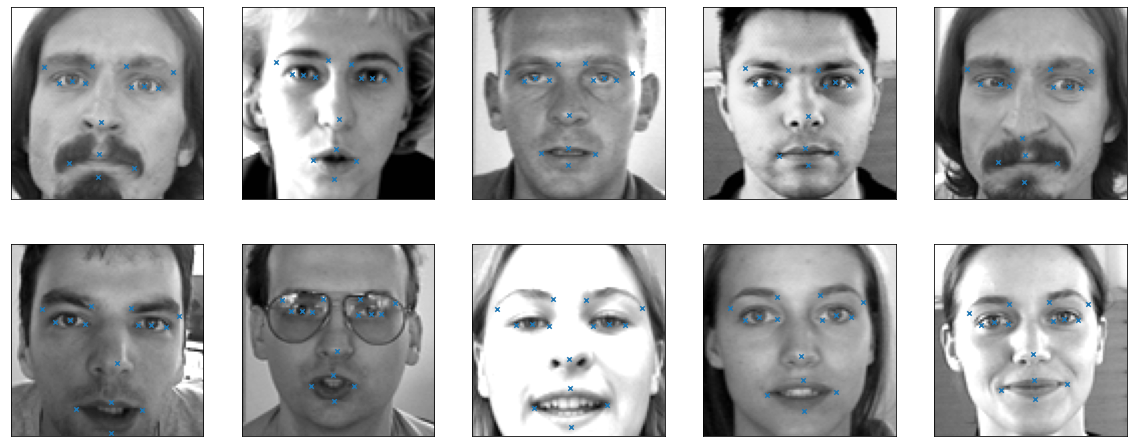

Shift Augmentation: 


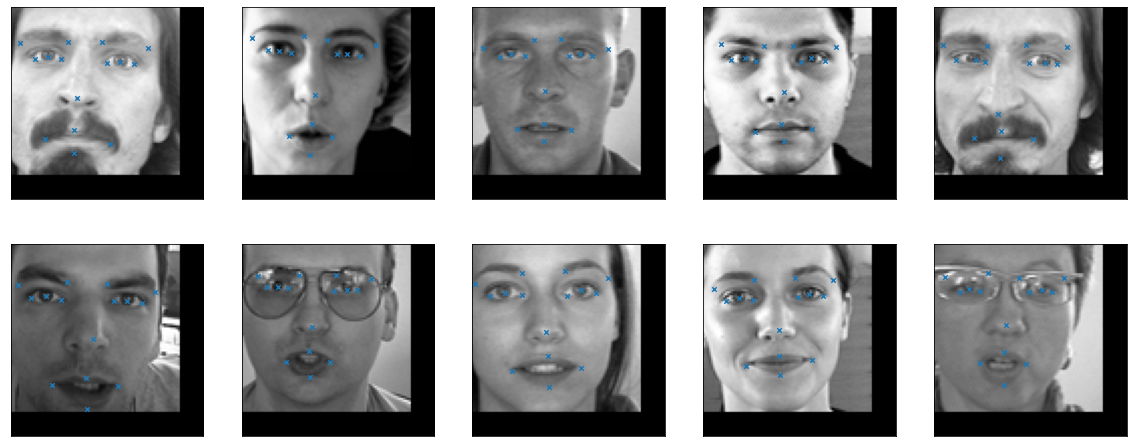

Random Noise Augmentation: 


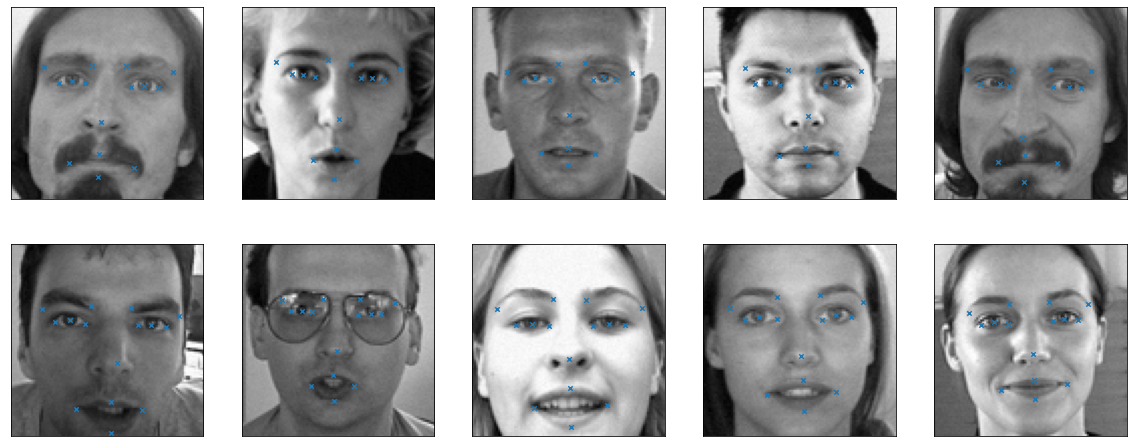

In [ ]:
print("Shape of final train_images:", np.shape(train_images))   #Thêm tất cả dữ liệu trước và sau khi nâng cao
print("Shape of final train_keypoints:", np.shape(train_keypoints))

print("\nClean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

print("Unclean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
plt.show()

if config.horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if config.rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()

if config.brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if config.shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()

if config.random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

# Model

In [ ]:
model = Sequential()

#Gửi hình ảnh đã xử lý vào mạng đặc trưng được đào tạo trước
#Application: Cung cấp một mô hình Keras với trọng lượng đào tạo trước
pretrained_model = applications.mobilenet_v2.MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')   #Mạng thân cây MobileNetV2 làm trích xuất đặc trưng

pretrained_model.trainable = True    #Không đóng băng

model.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=(96,96,1)))
model.add(layers.LeakyReLU(alpha = 0.1))
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())    #Tính toán mức trung bình của tất cả các điểm ảnh cho mỗi biểu đồ tính năng và xuất ra một giá trị dữ liệu
model.add(layers.Dropout(0.1))
model.add(layers.Dense(30))
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                           

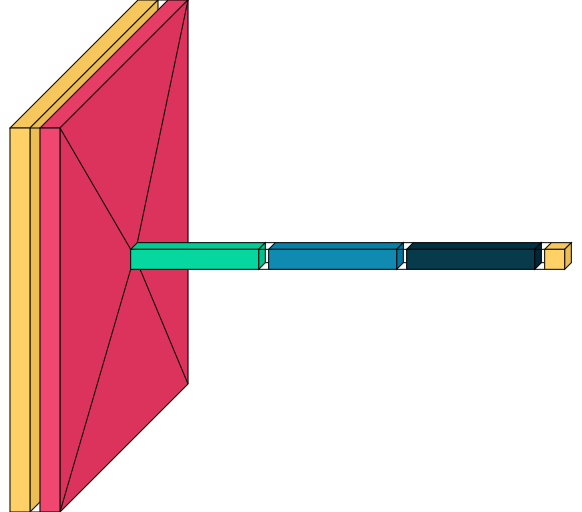

In [ ]:
# plot_model(model, show_shapes=True, expand_nested=True)
# visualkeras.layered_view(model)
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, show_layer_names=True,show_dtype=False,rankdir="TB")
visualkeras.layered_view(model)

## Training the model

In [ ]:
#Đào tạo trước
early_stop = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)

#Cấu hình phương pháp đào tạo
model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc']
)

#Ghi lại quá trình đào tạo: history
#model.fit : Thực hiện quá trình đào tạo
history = model.fit(
    train_images, train_keypoints, epochs=int(1.5*config.NUM_EPOCHS), batch_size=config.BATCH_SIZE,
    validation_split=0.05, callbacks=[early_stop, rlp]
)

Epoch 1/150
390/390 [==============================] - 49s 84ms/step - loss: 183.1275 - mae: 7.0833 - acc: 0.4937 - val_loss: 143.5780 - val_mae: 10.0056 - val_acc: 0.3110 - lr: 0.0010
Epoch 2/150
390/390 [==============================] - 32s 81ms/step - loss: 11.9474 - mae: 2.5638 - acc: 0.6222 - val_loss: 159.8742 - val_mae: 11.0731 - val_acc: 0.5945 - lr: 0.0010
Epoch 3/150
390/390 [==============================] - 31s 80ms/step - loss: 6.8119 - mae: 1.9088 - acc: 0.7098 - val_loss: 32.5072 - val_mae: 4.7565 - val_acc: 0.6212 - lr: 0.0010
Epoch 4/150
390/390 [==============================] - 31s 80ms/step - loss: 5.1901 - mae: 1.6633 - acc: 0.7633 - val_loss: 24.6051 - val_mae: 3.9449 - val_acc: 0.6227 - lr: 0.0010
Epoch 5/150
390/390 [==============================] - 31s 81ms/step - loss: 4.3116 - mae: 1.5170 - acc: 0.7855 - val_loss: 15.5751 - val_mae: 3.1650 - val_acc: 0.6265 - lr: 0.0010
Epoch 6/150
390/390 [==============================] - 32s 82ms/step - loss: 3.6912 - ma

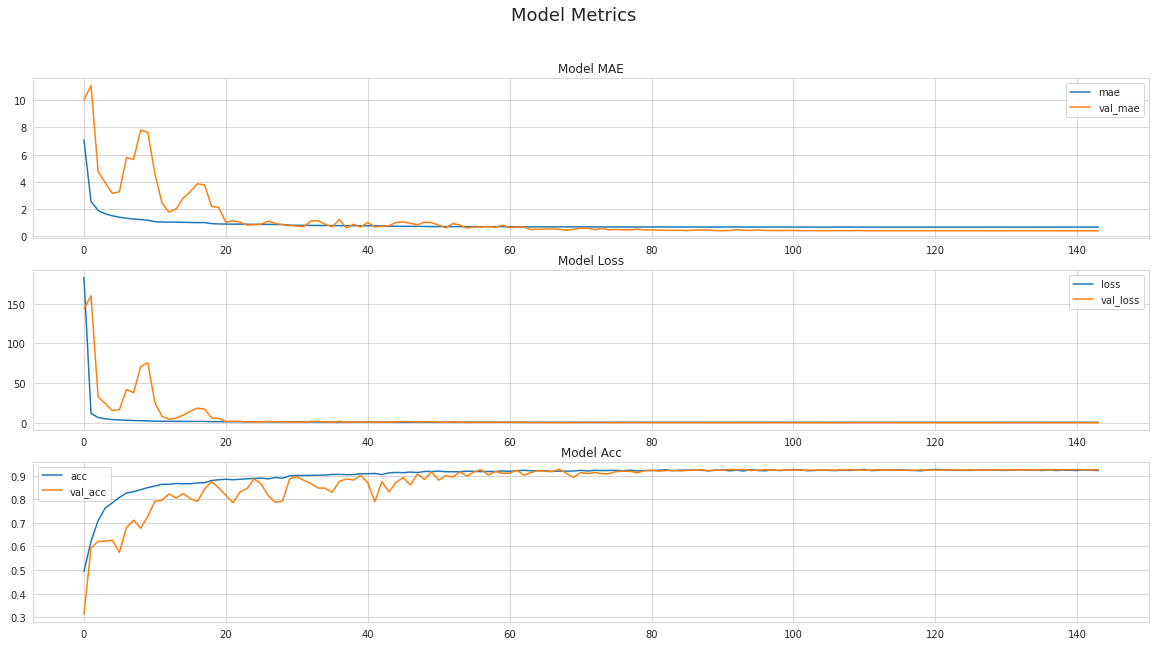

In [ ]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae', 'val_mae']].plot(ax=ax[0])       #validation
df[['loss', 'val_loss']].plot(ax=ax[1])
df[['acc', 'val_acc']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=12)     # Sai biệt tuyệt đối bình phương
ax[1].set_title('Model Loss', fontsize=12)
ax[2].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

### Fit the model on full dataset

In [ ]:
%%time
import tensorflow as tf
#Tinh chỉnh
early_stop = callbacks.EarlyStopping(
    monitor='loss', patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=5, min_lr=1e-15, mode='min', verbose=1
)


model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=history.history['lr'][-1]), loss='mean_squared_error', metrics=['mae', 'acc']
)

history = model.fit(
    train_images, train_keypoints, epochs=2*config.NUM_EPOCHS, batch_size=config.BATCH_SIZE, callbacks=[early_stop, rlp]
)

Epoch 1/200
410/410 [==============================] - 38s 81ms/step - loss: 0.8219 - mae: 0.6882 - acc: 0.9221 - lr: 6.1035e-08
Epoch 2/200
410/410 [==============================] - 33s 80ms/step - loss: 0.8294 - mae: 0.6907 - acc: 0.9226 - lr: 6.1035e-08
Epoch 3/200
410/410 [==============================] - 32s 78ms/step - loss: 0.8334 - mae: 0.6929 - acc: 0.9226 - lr: 6.1035e-08
Epoch 4/200
410/410 [==============================] - 32s 78ms/step - loss: 0.8226 - mae: 0.6887 - acc: 0.9240 - lr: 6.1035e-08
Epoch 5/200
410/410 [==============================] - 32s 78ms/step - loss: 0.8219 - mae: 0.6871 - acc: 0.9219 - lr: 6.1035e-08
Epoch 6/200
410/410 [==============================] - ETA: 0s - loss: 0.8277 - mae: 0.6902 - acc: 0.9236
Epoch 6: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
410/410 [==============================] - 32s 78ms/step - loss: 0.8277 - mae: 0.6902 - acc: 0.9236 - lr: 6.1035e-08
Epoch 7/200
410/410 [==============================] - 3

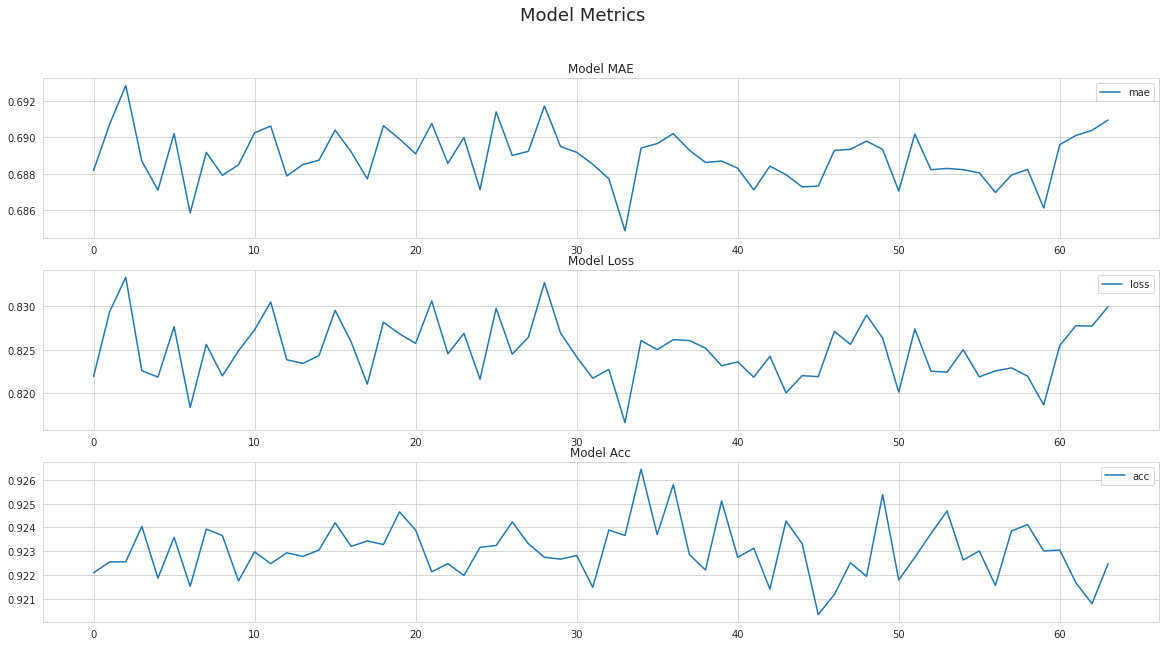

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
df = pd.DataFrame(history.history)
df[['mae']].plot(ax=ax[0])
df[['loss']].plot(ax=ax[1])
df[['acc']].plot(ax=ax[2])
ax[0].set_title('Model MAE', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
ax[2].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

## Predicting on Test Set

In [ ]:
%%time

test_preds = model.predict(test_images)

CPU times: user 1.7 s, sys: 30.2 ms, total: 1.73 s
Wall time: 1.69 s


## Visualizing Test Predictions

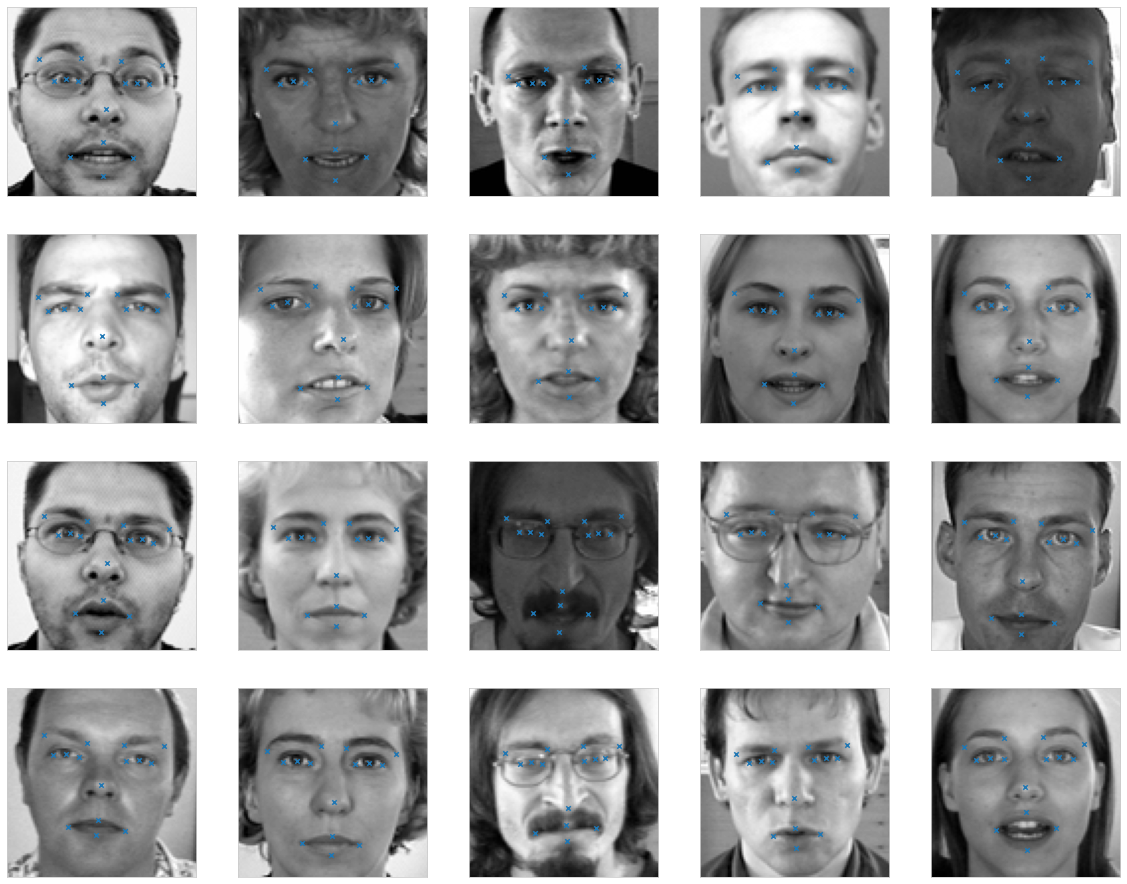

In [ ]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")